In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-30 15:21:01.736038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 15:21:02.195475: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 15:21:03.820874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_084


In [2]:
oof_2nd = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_2nd.head()

,series_id,step,score,event
0,038441c925bb,203,0.016615,wakeup
1,038441c925bb,203,0.092905,onset
2,038441c925bb,227,0.020050,wakeup
3,038441c925bb,227,0.092897,onset
4,038441c925bb,251,0.020097,wakeup


In [3]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.006441,0.000498
1,05e1944c3818,18,0.006160,0.000408
2,05e1944c3818,30,0.006053,0.000420
3,05e1944c3818,42,0.006288,0.000441
4,05e1944c3818,54,0.006586,0.000439


In [4]:
wakeup_2nd = oof_2nd[oof_2nd["event"]=="wakeup"]
onset_2nd = oof_2nd[oof_2nd["event"]=="onset"]
dfs = []
for seires_id, df in tqdm(oof_gru.groupby("series_id")):
    df2 = oof_2nd[oof_2nd["series_id"]==seires_id]
    max_step = max(df["step"].max(), df2["step"].max())
    base = pd.DataFrame({"series_id": [seires_id]*max_step, "step": range(max_step)})
    df = base.merge(df, on=["series_id", "step"], how="left")
    df["onset_oof"] = df["onset_oof"].interpolate(method="linear", direction="both").fillna(0)
    df["wakeup_oof"] = df["wakeup_oof"].interpolate(method="linear", direction="both").fillna(0)

    df2 = wakeup_2nd[wakeup_2nd["series_id"]==seires_id]
    df["wakeup_oof_2nd"] = df["step"].map(df2.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df2 = onset_2nd[onset_2nd["series_id"]==seires_id]
    df["onset_oof_2nd"] = df["step"].map(df2.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    df["wakeup_oof"] = df["wakeup_oof_2nd"] * 0.3 + df["wakeup_oof"] * 0.7
    df["onset_oof"] = df["onset_oof_2nd"] * 0.3 + df["onset_oof"] * 0.7
    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
del dfs
gc.collect()

100%|██████████| 277/277 [01:45<00:00,  2.63it/s]


0

12988639

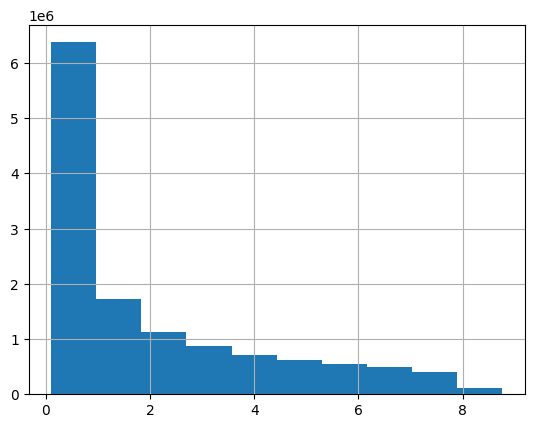

In [5]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.1]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.1]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [6]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:20<00:00, 13.82it/s]


In [7]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7875


event   tolerance
onset   12           0.252943
        36           0.667941
        60           0.776731
        90           0.821697
        120          0.854897
        150          0.870135
        180          0.888949
        240          0.903441
        300          0.909824
        360          0.917323
wakeup  12           0.330574
        36           0.665023
        60           0.766177
        90           0.812502
        120          0.844559
        150          0.860799
        180          0.878247
        240          0.898033
        300          0.910636
        360          0.920158
dtype: float64